In [4]:
# filename: minianalysis__cognate_variables.py
# 
# description: Runs models as specified originally and again after replacing a central variable by a cognate variable.
# It compares regressions on what was then the new data vs same regressions on future waves
# 
# inputs:
# 
# outputs:
# 
# @author: Misha Teplitskiy, mishateplitskiy@gmail.com
# 
# 2017-07-13 debugging z
#   1. trying getting rid of 'ddof=1' for IVs and only kept it for DV, to see if that would make a difference
#
#
#

from __future__ import division


import pandas as pd
import pickle

import sys
sys.path.append('../')    
import GSSUtility as GU # note, this imports the .PY file, so if I made changes to the IPYNB file, I first need to convert it 
                        # to PY for changes to actually take effect
                        # conversion can be done with 'jupyter nbconvert --to script GSSUtility.py'
import numpy as np
from numpy import nan
import statsmodels.formula.api as smf 
import random
from scipy.stats import pearsonr, ttest_ind, ttest_rel
import time
from collections import Counter
from collections import defaultdict


In [5]:
%rm ../GSSUtility_old.pyc

rm: cannot remove ‘../GSSUtility_old.pyc’: No such file or directory


In [6]:
%rm ../GSSUtility.pyc # remove this file because otherwise it will be used instead of the updated .py file
reload(GU)

<module 'GSSUtility' from '../GSSUtility.py'>

In [48]:
if __name__ == "__main__":    

    try:
        %rm ../GSSUtility.pyc # remove this file because otherwise it will be used instead of the updated .py file
        reload(GU)
    except:
        pass
    
    pathToData = '../../Data/'
    dataCont = GU.dataContainer(pathToData)
    
#     tempCognateOutput = open(pathToData + 'tempCognateOutput.txt', 'w')
    
    # contains for storing (variable, cognate) tuples in order to see what substitutions
    #i'm most commonly making
    variableCognateTuples = []
    
    # define the storage containers for outputs
    group1 = 'original model'
    group2 = 'cognate model'   
    groups = [group1, group2]
    outcomes = ['propSig', 'paramSizesNormed', 'Rs', 'adjRs', 'pvalues',  'numTotal', \
                'propSig_CentralVars', 'paramSizesNormed_CentralVars', 'pvalues_CentralVars']
    output = defaultdict(dict)
    output['metadata'] = {'article_id':[]}
    for group in groups:
        for outcome in outcomes:
            output[group][outcomes] = []
            
    
    articlesToUse = GU.filterArticles(dataCont.articleClasses, GSSYearsUsed=True, GSSYearsPossible=False, \
                                      centralIVs=True, linearModels=True) 
    
#     print 'Articles to use:', len(articlesToUse)

#     for article in random.sample(articlesToUse, 300):
    for article in articlesToUse:
#     for article in [a for a in articlesToUse if a.articleID == 1343]:
    
        print '\n\n\==============================\nProcessing article:', article.articleID

        # let's see if this article is suitable for cognates analysis:
        originalLHS = article.IVs + article.controls
        identifyCognatesReturns = GU.identifyCognates(dataCont, originalLHS, article.centralIVs, article.GSSYearsUsed, corrThreshold=0.6 )        
        if not identifyCognatesReturns: 
            print 'No suitable cognates. Skipping.'            
            continue        
        else: 
            cIV, cognate, GSSYearsWithCognate = identifyCognatesReturns
#             cognate = str(cognate)
#             print 'just identified cIV:', cIV, 'and cognate', cognate
#             print article.centralIVs
            
        # if we got this far, then this article does have suitable cognates, so let's estimate models       
        # Now let's estimate the models
        print 'overall cIV is', cIV, 'and cognate is', cognate
        for DV in article.DVs:            
            
            if cognate == DV: continue # sometimes the cognate suggested by GU.identifyCognates is the DV

            cognateLHS = originalLHS[:] # the "[:]" makes a deep copy ?
            cognateLHS.remove(cIV)
            cognateLHS.append(cognate) # need to put it in list otherwise it treats each letter as an element
#                 print 'Substituting', cIV, 'with cognate', cognate     
            # make sure cIV is last in the list of variables
            originalLHS.remove(cIV)
            originalLHS.append(cIV) 
                
            for year in GSSYearsWithCognate:        

                # group 2 model (with cognates)
                result_cog = GU.runModel(dataCont, year, DV, cognateLHS)          
                if not result_cog: continue # results will be None if the formula cant be estimated
#                 print 'cognate model:', DV, '~', cognateLHS, 'on year', year
                 
                # group 1 model (original)
                result_orig = GU.runModel(dataCont, year, DV, originalLHS)                     
                if not result_orig: continue # results will be None if the formula cant be estimated
#                 print 'original model:', DV, '~', originalLHS, 'on year', year
                
                results = [result_orig, result_cog]

                # BUILD LIST OF CENTRAL VARIABLES
                # first with the original model
                centralVarsOrig, centralVarsCognate = [], []            
                
                for civ in article.centralIVs:
                    if 'standardize(%s, ddof=1)' % (civ) in results[0].params.index:
                        centralVarsOrig.append('standardize(%s, ddof=1)' % (civ))
                    else: 
                        for col in results[0].params.index:
                            if 'C(' + civ + ')' in col:
                                centralVarsOrig.append(col)          
                                
                # now the COGNATE model
                cIVs_cognate = article.centralIVs[:]
                try:
                    cIVs_cognate.remove(cIV)
                    cIVs_cognate.append(cognate)
#                     print 'building cognate model'
#                     print 'removing civ', cIV, 'and adding cognate', cognate
                except:
                    print 'building model didnt work. tried to remove', cIV, 'and append', cognate, 'from\n'
                    print cIVs
                    break
                
#                 print 'article.centralIVs', article.centralIVs
#                 print 'cIVs_cognate', cIVs_cognate
#                 print
                
                for civ in cIVs_cognate:
                    if 'standardize(%s, ddof=1)' % (civ) in results[1].params.index:
                        centralVarsCognate.append('standardize(%s, ddof=1)' % (civ))
                    else: 
                        for col in results[1].params.index:
                            if 'C(' + civ + ')' in col:
                                centralVarsCognate.append(col)
                                
                centralVars = [centralVarsOrig, centralVarsCognate]
                
                # the condition below means that i don't care about models in which orig var isn't stat. sig.
                # A reason for this condition is that if this central variable isn't significant in the original model
                # then the goal of the article may've been to show that this variable DOESN'T matter. In such a "negative" case,
                # what does replacing it with a cognate accomplish?

                # old condition below
#                 if result_orig.pvalues[-1] > 0.05: continue
                # new condition below
#                 if np.all(results[0].pvalues[centralVars] > 0.05): 
#                     print 'All "central" IVs are p > 0.05. Skipping.'
#                     continue                
                
                # Checks on which results to record                
                if len(result_cog.params) != len(result_orig.params):
                    print 'The number of variables in original model is different from the number in cognate model. Skipping.'                    
                    continue

                
                # NOW "RECORD" THE OUTPUTS FROM THESE MODELS
                
                for i in range(2):                 
                    output[groups[i]]['Rs'].append(results[i].rsquared) 
                    output[groups[i]]['adjRs'].append(results[i].rsquared_adj) 
                    output[groups[i]]['propSig'].append(float(len([p for p in results[i].pvalues[1:] if p < 0.05]))/len(results[i].params[1:])) 
                    output[groups[i]]['paramSizesNormed'].append(np.mean(results[i].params[1:].abs())) 
                    output[groups[i]]['pvalues'].append(np.mean( results[i].pvalues[1:]))
                    output[groups[i]]['numTotal'].append( 1 ) #divide by len of R^2 array to get a mean of variables estimated PER model                           

                    if len(centralVars[0])>0: # need to look into first element because even empty centralVars is 2-elements: [[], []]
                        output[groups[i]]['pvalues_CentralVars'].append(np.mean(results[i].pvalues[centralVars[i]]))               
                        output[groups[i]]['propSig_CentralVars'].append(float(len([p for p in results[i].pvalues[centralVars[i]] if p < 0.05])) \
                                                                /len(results[i].params[centralVars[i]])) 
                        output[groups[i]]['paramSizesNormed_CentralVars'].append(np.mean(results[i].params[centralVars[i]].abs()))                
                    else:
                        output[groups[i]]['pvalues_CentralVars'].append(nan)               
                        output[groups[i]]['propSig_CentralVars'].append(nan) 
                        output[groups[i]]['paramSizesNormed_CentralVars'].append(nan)                
                
                output['metadata']['article_id'].append(article.articleID)  
                
                break
                
                
    print '\n\n============================================\nFINISHED RUNNING MODELS'

# I dump the file here, because this allows me to run this script as a standalone .py file in command line...
# it saves the output fine, and then crashes (intentionally) when it gets to the viz part further below
pickle.dump(output, open('output.pickle', 'w'))



\==============================
Processing article: 4055
No cognates for the specified central IVs
No suitable cognates. Skipping.


\==============================
Processing article: 2558
No cognates for the specified central IVs
No suitable cognates. Skipping.


\==============================
Processing article: 4434
overall cIV is EDUC and cognate is DEGREE


\==============================
Processing article: 4266
No cognates for the specified central IVs
No suitable cognates. Skipping.


\==============================
Processing article: 6439
overall cIV is EDUC and cognate is SPEDUC


\==============================
Processing article: 4007
Could not find suitable cognate. Skipping.
No suitable cognates. Skipping.


\==============================
Processing article: 1043
No cognates for the specified central IVs
No suitable cognates. Skipping.


\==============================
Processing article: 4133
No cognates for the specified central IVs
No suitable cognates. Skipping.

Dropping column WKSUB because it is constant
Couldnt construct a suitable formula
Dropping column WKSUB because it is constant
Couldnt construct a suitable formula
Dropping column WKSUB because it is constant
Couldnt construct a suitable formula
Dropping column WKSUB because it is constant
Couldnt construct a suitable formula


\==============================
Processing article: 6161
overall cIV is PAEDUC and cognate is MAEDUC
Dropping column WKSUB because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUB because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUB because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUB because it is constant
Dropping column WKSUP because it is constant


\==============================
Processing article: 6460
No cognates for the specified central IVs
No suitable cognates. Skipping.


\==============================
Processing article: 6642
No cognates for t

overall cIV is EDUC and cognate is SPEDUC
Couldnt construct a suitable formula


\==============================
Processing article: 1962
overall cIV is ATTEND and cognate is SPATTEND


\==============================
Processing article: 1965
Could not find suitable cognate. Skipping.
No suitable cognates. Skipping.


\==============================
Processing article: 1179
Could not find suitable cognate. Skipping.
No suitable cognates. Skipping.


\==============================
Processing article: 1202
No cognates for the specified central IVs
No suitable cognates. Skipping.


\==============================
Processing article: 1307
overall cIV is ATTEND and cognate is SPATTEND


\==============================
Processing article: 1310
overall cIV is EDUC and cognate is DEGREE


\==============================
Processing article: 1340
overall cIV is ATTEND and cognate is SPATTEND


\==============================
Processing article: 2112
overall cIV is EDUC and cognate is DEGREE


\



\==============================
Processing article: 3194
overall cIV is EDUC and cognate is SPEDUC


\==============================
Processing article: 3231
overall cIV is EDUC and cognate is SPEDUC


\==============================
Processing article: 3250
overall cIV is PAEDUC and cognate is MAEDUC
Dropping column WKSUP because it is constant
Couldnt construct a suitable formula
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is constant
Couldnt construct a suitable formula
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUP because it is 



\==============================
Processing article: 5756
Could not find suitable cognate. Skipping.
No suitable cognates. Skipping.


\==============================
Processing article: 5862
No cognates for the specified central IVs
No suitable cognates. Skipping.


\==============================
Processing article: 5944
No cognates for the specified central IVs
No suitable cognates. Skipping.


\==============================
Processing article: 5982
overall cIV is DEGREE and cognate is EDUC


\==============================
Processing article: 6007
overall cIV is MAEDUC and cognate is MADEG
Couldnt construct a suitable formula
Couldnt construct a suitable formula
Couldnt construct a suitable formula
Couldnt construct a suitable formula
Couldnt construct a suitable formula
Couldnt construct a suitable formula
Couldnt construct a suitable formula
Couldnt construct a suitable formula
Couldnt construct a suitable formula


\==============================
Processing article: 6060
No co

Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping column MARITAL because it is constant
Dropping colu

Dropping column WKSUB because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUB because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUB because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUB because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUB because it is constant
Dropping column WKSUP because it is constant
Dropping column WKSUB because it is constant
Dropping column WKSUP because it is constant
Couldnt construct a suitable formula


\==============================
Processing article: 1183
overall cIV is EDUC and cognate is SPEDUC


\==============================
Processing article: 1533
overall cIV is EDUC and cognate is DEGREE


\==============================
Processing article: 3846
No cognates for the specified central IVs
No suitable cognates. Skipping.


\==============================
Processing article: 1814
Could not find suitable cogna



\==============================
Processing article: 5838
No cognates for the specified central IVs
No suitable cognates. Skipping.


\==============================
Processing article: 5949
No cognates for the specified central IVs
No suitable cognates. Skipping.


\==============================
Processing article: 6336
overall cIV is EDUC and cognate is DEGREE


\==============================
Processing article: 6364
overall cIV is SPKHOMO and cognate is COLHOMO


\==============================
Processing article: 6532
No cognates for the specified central IVs
No suitable cognates. Skipping.


\==============================
Processing article: 6731
No cognates for the specified central IVs
No suitable cognates. Skipping.


\==============================
Processing article: 7282
overall cIV is DOTPRES and cognate is DOTSVP


\==============================
Processing article: 5015
No cognates for the specified central IVs
No suitable cognates. Skipping.


\======================

# Break
This and the following cells are designed to do an intermediate output --> input step, so that I can run this script WITHOUT graphics (command line), and then just come to this notebook to VISUALIZE the results

In [7]:
# load the output pickle after running models
output = pickle.load(open('output.pickle'))

group1 = 'original model'
group2 = 'cognate model'   
groups = [group1, group2]
outcomes = ['propSig', 'paramSizesNormed', 'Rs', 'adjRs', 'pvalues',  'numTotal', \
            'propSig_CentralVars', 'paramSizesNormed_CentralVars', 'pvalues_CentralVars']

df_output = pd.DataFrame(index=np.arange(len(output[group1]['propSig'])), columns=pd.MultiIndex.from_product([groups, outcomes]))
df_output.columns.names = ['outcome','group']
for outcome in outcomes:
    for gp in groups:
        df_output[gp, outcome] = output[gp][outcome]
df_output.index = output['metadata']['article_id']
df_output['article_id'] = output['metadata']['article_id']
del df_output[group1, 'numTotal']
del df_output[group2, 'numTotal']

print 'Using %f models from %f articles' % (len(df_output), len(df_output.index.unique()))


KeyError: 'propSig'

In [5]:
# output article IDs for use in replication project. 2016-06-07
'''
fout = open('minianalysis_cognate_variables_list_of_articles_used.csv',  'wb')
fout.write(','.join(map(str, sorted(df_output.index.unique())))) # unique article IDs used, separated by commas
fout.close()
'''

"\nfout = open('minianalysis_cognate_variables_list_of_articles_used.csv',  'wb')\nfout.write(','.join(map(str, sorted(df_output.index.unique())))) # unique article IDs used, separated by commas\nfout.close()\n"

## The part below is where running command-line script should crash

In [6]:
# %matplotlib inline
# # #Plot outcomes - (new) distribution of differences approach

# outcomeMap = {'propSig':"% of Stat. Sign. Coeff's", 
#               'paramSizesNormed':"Standard. Size of Coeff's",
#               'Rs':'R-squared', 
#               'adjRs':'Adj. R-squared',
#               'pvalues':"Avg. P-Value of Coeff's",
#               'propSig_CentralVars':"Central IVs: % of Stat. Sign. Coeff's",
#               'paramSizesNormed_CentralVars':"Central IVs: Standard. Size of Coeff's", 
#               'pvalues_CentralVars':"Central IVs: Avg. P-Value of Coeff's"}

# outcomeXlimits = {'propSig':(-.2,.2), 
#               'paramSizesNormed':(-.04,.04),
#               'Rs':(-.04, .06), 
#               'adjRs':(-.04, .06),
#               'pvalues':(-.2, .2),
#               'propSig_CentralVars':(-.2, .4),
#               'paramSizesNormed_CentralVars':(-.1,.1), 
#               'pvalues_CentralVars':(-.2, .2)}

# outcomeYlimits = {'propSig':80, 
#               'paramSizesNormed':100,
#               'Rs':120, 
#               'adjRs':120,
#               'pvalues':17,
#               'propSig_CentralVars':8.5,
#               'paramSizesNormed_CentralVars':40, 
#               'pvalues_CentralVars':11.5}

# for outcome in outcomes:
#     plt.figure(figsize=(3,3))
#     if outcome=='article_id': continue
#     if outcome=='numTotal':continue

#     plt.xticks(fontsize=12)
#     plt.locator_params(nbins=7)
#     plt.yticks(fontsize=15)
#     plt.ylabel('Density', fontsize=17)
#     plt.title(outcomeMap[outcome], fontsize=20)
#     plt.xlim(outcomeXlimits[outcome])    
    
#     sb.kdeplot((df_output[group1, outcome] - df_output[group2, outcome]), 
#                 color='black', legend=False, shade=True)
#     plt.plot([0,0], [0,outcomeYlimits[outcome]], '--', color='black', linewidth=2)
    
# #     plt.savefig('images/cognate-differences--' + outcome + '.png', bbox_inches='tight')
# #     break

# # <markdowncell>

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb
custom_style = {'axes.facecolor': 'white',
                'grid.color': '0.15',
                'grid.linestyle':'-.'}
sb.set_style("darkgrid", rc=custom_style)

(array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8]),
 <a list of 10 Text yticklabel objects>)

/usr/lib64/python2.7/site-packages/matplotlib/collections.py:526: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


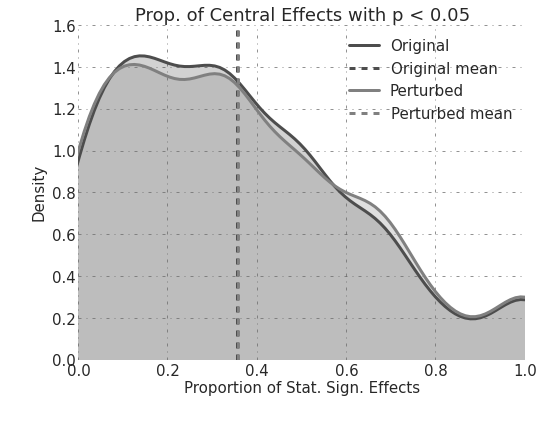

In [8]:
# ONE EXAMPLE OF DIFFERENCES IN DISTRIBUTION: PROP OF STAT. SIGN. EFFECTS FOR CENTRAL VARS
plt.figure(figsize=(8,6))
sb.kdeplot(df_output[group1, 'propSig_CentralVars'], color='0.3', shade=True, label='Original', linewidth=3)
plt.plot([df_output[group1, 'propSig_CentralVars'].mean()]*2, [0,2], '--', c='0.3', linewidth=3, label='Original mean')
sb.kdeplot(df_output[group2, 'propSig_CentralVars'], color='0.5', shade=True, label='Perturbed', linewidth=3)
plt.plot([df_output[group2, 'propSig_CentralVars'].mean()]*2, [0,2], '--', c='0.5', linewidth=3, label='Perturbed mean')
plt.legend(loc='best', fontsize=15)
plt.title('Prop. of Central Effects with p < 0.05', fontsize=18)
plt.xlabel('Proportion of Stat. Sign. Effects', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xlim(0, 1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig('images/cognate-example-of-differences-in-distributions-prop-sign-of-central-effects.png', bbox_inches='tight', dpi=150)

In [34]:
# # #Plot outcomes - (old) bar chart approach
# %matplotlib inline

# plt.figure(figsize=(14,8))
# outcomesToUse = df_output[group1].columns
# indices = np.arange(len(outcomesToUse))
# width = 0.35
# error_config = {'ecolor': '0.3'}

# axes = plt.figure().add_subplot(111)
# rects1 = plt.bar(left=indices, width=width, height=df_output[group1].mean(), color='0.75', 
#              yerr=2*df_output[group1].std()/np.sqrt(len(df_output[group1])),
#              error_kw=error_config) #this is not very relevant because we're not comparing independent groups
# rects2 = plt.bar(left=indices+width, width=width, height=df_output[group2].mean(), color='0.5', 
#              yerr=2*df_output[group2].std()/np.sqrt(len(df_output[group2])),
#              error_kw=error_config)

# # title, legend, etc
# plt.title('Original vs. Cognate Models', fontsize=18)
# plt.legend((rects1[0], rects2[0]), ('Original models', 'Cognate models'), fontsize=15)
# # legend((rects1[0], rects2[0]), ('Original models', 'Cognate models'), fontsize=15)
# plt.xlim((-1*width, len(outcomesToUse)))

# # tick labels
# # a = outcomesToUse
# a = ['% of coeffs. stat. sign.', 'avg. coeff. size', 'R_sq.', 'adj. R_sq.', 'avg. p-value', \
#      '"central" vars: % of coeffs. stat. sign.', '"central" vars: avg. coeff. size', '"central" vars: avg. p-value']
# axes.set_xticks(indices+width)
# axes.set_xticklabels(a, rotation=90, fontsize=15)

# # label the bars with the difference between them
# diffs = (df_output[group1] - df_output[group2]).mean().values
# def autolabel(rects):
#     # attach some text labels
#     for i, rect in enumerate(rects):
#         height = rect.get_height()
#         if i!=7 and i!=4:
#             axes.text(rect.get_x()+width, 1.03*height, '%0.3f'%diffs[i],
#                     ha='center', va='bottom', fontsize=15)
#         else: # this is for the p-value label, which has gone up
#             axes.text(rect.get_x()+width, 1.03*height+0.05, '%0.3f'%diffs[i],
#                     ha='center', va='bottom', fontsize=15)
# autolabel(rects1)

# # plt.figure(figsize=(6,5))
# # (df_output[group1]['paramSizesNormed'] - df_output[group2]['paramSizesNormed']).plot(kind='kde')
# # plt.plot([0,0], [0,20], '--')
# # plt.title('Differences in Stand. Coeff. Size. between orig. and cognate')

# # # <codecell>

# # mn= np.mean((df_output[group1, 'Rs'] - df_output[group2, 'Rs']).values)
# # sd= np.std((df_output[group1, 'Rs'] - df_output[group2, 'Rs']).values)
# # print mn, sd, mn/(sd/np.sqrt(df_output.shape[0]))

# # <markdowncell>

In [35]:
# #temp fix to convert proportions into percentages
# for group in [group1, group2]:
#     for o in ['propSig', 'propSig_CentralVars']:
#         df_output[group, o] = df_output[group, o]/100

/home/t-9tepli/.local/lib/python2.7/site-packages/statsmodels-0.8.0-py2.7-linux-x86_64.egg/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(-10, 10)

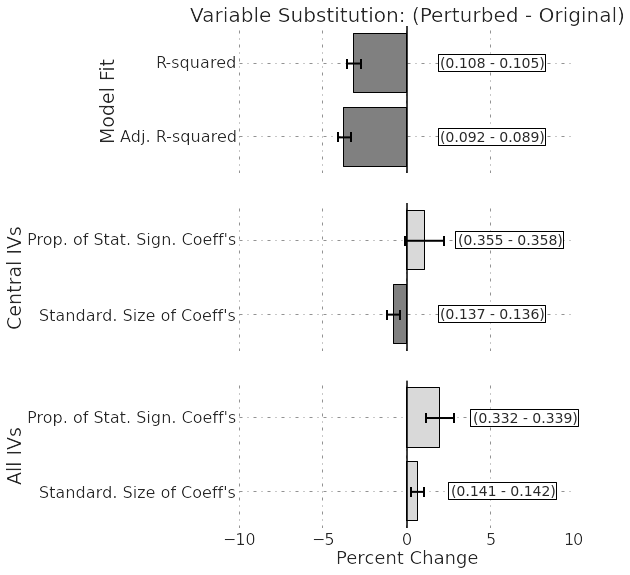

In [9]:
%matplotlib inline

# fig = plt.figure(figsize=(6,9))
outcomesToUse = [u'adjRs',
                 u'Rs',
                 u'paramSizesNormed_CentralVars',                
                 u'propSig_CentralVars', 
                 u'paramSizesNormed',
                 u'propSig']

outcomeMap = {'propSig':"Prop. of Stat. Sign. Coeff's", 
              'paramSizesNormed':"Standard. Size of Coeff's",
              'Rs':'R-squared', 
              'adjRs':'Adj. R-squared',
#               'pvalues':"Avg. P-Value of Coeff's",
              'propSig_CentralVars':"Prop. of Stat. Sign. Coeff's",
              'paramSizesNormed_CentralVars':"Standard. Size of Coeff's", 
              'pvalues_CentralVars':"Avg. P-Value of Coeff's"}

# indices = [1,2,4,5,7,8]
width = 0.5
error_config = dict(ecolor='0', lw=2, capsize=5, capthick=2)

diffs = [100*(df_output[group2, outcome] - df_output[group1, outcome]).mean()/df_output[group1, outcome].mean() for outcome in outcomesToUse]
diffs_strings = ['(%0.3f - %0.3f)' % (df_output[group1, outcome].mean(), df_output[group2, outcome].mean()) 
                 for outcome in outcomesToUse]
diffs = np.array(diffs)

# naive SES
# ses = [(df_output[group1, outcome] - df_output[group2, outcome]).std()/np.sqrt(len(df_output)) for outcome in outcomesToUse]

# clustered SES
clusteredSES = []
article_ids = np.array(list(df_output.index)) 
for outcome in outcomesToUse:
    diff = 100*(df_output[group2, outcome] - df_output[group1, outcome])
    mask = ~np.isnan(np.array(diff))
    result_clustered = smf.ols(formula='y~x-1', \
                     data=pd.DataFrame({'y':diff[mask], 'x':[1]*len(diff[mask])})).fit(missing='drop', \
                                                                             cov_type='cluster', \
                                                                    cov_kwds=dict(groups=article_ids[mask]))
    clusteredSES.append(result_clustered.HC0_se[0])
clusteredSES = np.array(clusteredSES)

# CONSERVATIVE TESTs
# these will be based only on n. of articles
conservativeSES = []
for outcome in outcomesToUse:
    df_output_copy = df_output.copy()
    df_output_copy['difference'] = 100*(df_output[group2, outcome] - df_output[group1, outcome])
    mean_difference = df_output_copy.groupby('article_id').difference.mean()
    se = np.std(mean_difference) / np.sqrt(len(mean_difference))
    conservativeSES.append(se)
conservativeSES = np.array(conservativeSES)


colors = ['0.5' if el < 0 else '0.85' for el in diffs]

# plt.barh(indices, diffs, xerr=2*np.array(clusteredSES), align='center', color=colors, error_kw=error_config)
# axes.set_yticks(indices)
# axes.set_yticklabels([outcomeMap[o] for o in outcomesToUse], fontsize=17)

f, axarr = plt.subplots(3, sharex=True, figsize=(6,9))
                        
for i in range(3):
    # bars
#     xerr = 2*clusteredSES[i*2:i*2+2] / diffs[i*2:i*2+2] # i am dividing here because we want the SEs to be on the percent-change scale, not raw scale
    xerr = 2*conservativeSES[i*2:i*2+2]
    boxes = axarr[i].barh([0,1], diffs[i*2:i*2+2], xerr=xerr, 
             align='center', color=colors[i*2:i*2+2], error_kw=error_config)
   
    # annotate boxes: raw means
    box0_xcoord = boxes[0].get_bbox().get_points()[1,0] + 2 # the indices here mean get the x-coord of 2nd box corner
    box1_xcoord = boxes[1].get_bbox().get_points()[1,0] + 2

    axarr[i].text(box0_xcoord, 0, diffs_strings[i*2], fontsize=14,
                 verticalalignment='center',
                 bbox=dict(facecolor='white', alpha=1), style='italic')
    axarr[i].text(box1_xcoord, 1, diffs_strings[i*2+1], fontsize=14,
                 verticalalignment='center',
                 bbox=dict(facecolor='white', alpha=1), style='italic')

    #labels for y-axis
    axarr[i].set_yticks([0,1])
    axarr[i].set_yticklabels([outcomeMap[o] for o in outcomesToUse[i*2:i*2+2]], fontsize=16)
    axarr[i].plot([0,0], [-0.5,1.5], linewidth=2, c='black', alpha=.75)    
 
    
axarr[0].set_title('Variable Substitution: (Perturbed - Original)', fontsize=20)
axarr[0].set_ylabel('Model Fit', fontsize=19)
axarr[1].set_ylabel('Central IVs', fontsize=19)
axarr[2].set_ylabel('All IVs', fontsize=19)
axarr[2].set_xlabel('Percent Change', fontsize=18)
plt.xticks(fontsize=16)
plt.xlim(-10,10)

# plt.title('Original vs. Cognate Models', fontsize=20)
# plt.xlabel('% change from original to cognate', fontsize=17)
# plt.xticks(fontsize=15)

# plt.plot([0,0], [-0.5,7.5], linewidth=2, c='black', alpha=.75)

# plt.savefig('images/cognate--original-minus-perturbed.png', bbox_inches='tight', dpi=150)

In [55]:
df_output

outcome original model                                                     \
group          propSig paramSizesNormed        Rs     adjRs       pvalues   
4434          0.500000         0.300062  0.110080  0.103040  1.498043e-01   
4434          0.500000         0.311082  0.220795  0.214631  1.446405e-01   
4434          0.333333         0.220968  0.088915  0.081708  2.432155e-01   
4434          0.583333         0.284535  0.123302  0.116367  1.265076e-01   
4434          0.416667         0.195580  0.134418  0.127571  3.042835e-01   
4434          0.250000         0.248542  0.066169  0.058782  2.102993e-01   
4434          0.333333         0.200931  0.053892  0.046408  3.030416e-01   
4434          0.166667         0.099779  0.017418  0.009646  5.579318e-01   
4434          0.000000         0.081589  0.005116 -0.002753  5.499602e-01   
4434          0.250000         0.202865  0.101034  0.093923  4.358852e-01   
4434          0.583333         0.335490  0.164197  0.157585  8.793432e-02   
6439          0.578947         0.261895  0.160318  0.149703  2.099939e-01   
6439          0.526316         0.224126  0.209662  0.199671  2.639485e-01   
6439          0.631579         0.297164  0.121285  0.110177  1.896982e-01   
6439          0.526316         0.271429  0.123849  0.112773  1.509528e-01   
6439          0.421053         0.197032  0.088802  0.077284  2.486042e-01   
6439          0.526316         0.258554  0.103890  0.092562  1.638455e-01   
6439          0.631579         0.292664  0.117307  0.106149  2.103167e-01   
6439          0.210526         0.135920  0.107546  0.096264  3.244467e-01   
6439          0.315789         0.210782  0.171298  0.160822  2.537317e-01   
6439          0.473684         0.233485  0.205410  0.195366  1.212827e-01   
6439          0.210526         0.113734  0.097479  0.086070  4.699087e-01   
6439          0.368421         0.185395  0.189121  0.178870  2.931793e-01   
6439          0.368421         0.184664  0.234331  0.224652  2.956140e-01   
6439          0.421053         0.181293  0.209257  0.199261  2.418852e-01   
6439          0.315789         0.153289  0.196790  0.186637  3.535007e-01   
6439          0.368421         0.165377  0.211942  0.201980  3.140012e-01   
6439          0.263158         0.153097  0.214528  0.204599  3.208050e-01   
6840          0.666667         0.375133  0.162864  0.156585  1.223332e-01   
224           1.000000         0.245908  0.297403  0.296455  3.550039e-12   
...                ...              ...       ...       ...           ...   
3095          0.666667         0.096606  0.042899  0.041098  4.256059e-02   
3095          0.666667         0.088140  0.038480  0.036671  8.205890e-02   
3095          0.666667         0.129937  0.082472  0.080746  5.931897e-02   
3095          0.666667         0.061830  0.020874  0.019033  2.911215e-01   
3095          0.666667         0.128127  0.086445  0.084727  1.618981e-01   
3095          0.666667         0.132283  0.087165  0.085448  2.068061e-02   
3095          0.666667         0.074089  0.022877  0.021039  5.608270e-02   
3095          0.333333         0.084159  0.042158  0.040356  1.303534e-01   
3095          0.333333         0.071284  0.036004  0.034191  3.754579e-01   
3095          1.000000         0.082263  0.028062  0.026234  9.411530e-03   
3095          0.333333         0.068621  0.029987  0.028162  3.406284e-01   
3095          0.666667         0.091109  0.047522  0.045730  2.378670e-01   
3095          0.666667         0.090498  0.039769  0.037963  5.949560e-02   
3095          0.333333         0.078729  0.046651  0.044858  4.252681e-01   
3095          0.666667         0.080934  0.039705  0.037899  2.374917e-01   
3095          1.000000         0.093946  0.041839  0.040037  2.486444e-02   
3095          0.666667         0.043204  0.007530  0.005663  2.077186e-01   
3095          1.000000         0.113677  0.050723  0.048938  7.513019e-03   
3095          1.000000         0.125430  0.050044  0.048257  8.223653e-03

In [ ]:
# box = rects[0].get_bbox()
# box.

In [ ]:
# Perform t-tests and Tests using *clustered errors*
# --
# 
# 1. Perform related-sample t-test (samples must be of equal lengths)
# 
# 2. Perform independent samples t-test (just for kicks, to see how big our effects are)
# 
# 3. Perform clustered error tests. To do this I will do a hack by running a regression with clustered errors and using that as the t-test. Source/inspiration is: http://www.stata.com/statalist/archive/2010-05/msg00663.html
# 
# Note: I am not using the 'df_correction' flag in get_robustcov_results() because that's apparently something HLM does, not canonical clustered errors:
# "This method of correcting the standard errors to account for the intraclass correlation is a "weaker" form of correction than using a multilevel model, which not only accounts for the intraclass correlation, but also corrects the denominator degrees of freedom for the number of clusters."
# source: http://www.ats.ucla.edu/stat/stata/library/cpsu.htm
# 
# Note
# --
# For some reason, I'm getting different clustered-errors-p-values when I use the 'cluster' flag in the 
# fit() function vs. when I calculate the result normally and then use get_robustcov_results function on that result. The former method yields slightly smaller p-values.
# 
# Outcome
# --
# The p-values are larger (for some outcomes, they are now > 0.05) but are still sufficiently small?

# <codecell>
try: outcomes.remove('numTotal')
except: pass

# <codecell>

# (df_output['adjRs','orig. models'] - df_output['adjRs','cognate models']).plot(kind='kde')

from scipy.stats import ttest_1samp
import statsmodels.formula.api as smf

for outcome in outcomes:
    print outcome
    print 'Mean before substitution:', df_output[group1, outcome].mean()
    print 'Mean after substitution:', df_output[group2, outcome].mean()
    print 'Related samples t-test p-value:', np.around(ttest_rel(df_output[group1, outcome], df_output[group2, outcome])[1], 6)
 
    # GET CLUSTERED ERRORS
    # to do this run a regression Y ~ X where Y = outcomes, X = dummy {0=group1, 1=group2}
    # 1. Define variables
    outcomes_combined = list(df_output[group1, outcome]) + list(df_output[group2, outcome])
    diffs = df_output[group1, outcome] - df_output[group2, outcome]
    dummy = [0]*len(df_output[group1, outcome]) + [1]*len(df_output[group2, outcome])
    article_ids = np.array(list(df_output.index)) 
    
    # 2. Fit models
#     result = smf.ols(formula='y~x', data=pd.DataFrame({'y':outcomes_combined, 'x':dummy})).fit() # do I need a constant???
#     result = smf.ols(formula='y~x-1', data=pd.DataFrame({'y':diffs, 'x':[1]*len(diffs)})).fit()
    mask = ~np.isnan(np.array(diffs))
    result_clustered = smf.ols(formula='y~x-1', \
                     data=pd.DataFrame({'y':diffs[mask], 'x':[1]*len(diffs[mask])})).fit(missing='drop', \
                                                                             cov_type='cluster', \
                                                                    cov_kwds=dict(groups=article_ids[mask]))
                                                                                               
# these two methods produce slightly different results. neither is necessary because i'm using parameters
# of the model.fit() method above instead to use clustered standard errors.
#     # 3. Get clustered standard errors
#     robust_results = result.get_robustcov_results(cov_type='cluster', 
#                                                   use_correction=True,
#                                                   groups=article_ids, # this is article_id doubled
#                                                   df_correction=True) 
    
#     # 3.1 Get clustered standard errors another way, by regression diffs ~ const and seeing if const!=0
#     result_rob = result.get_robustcov_results(cov_type='cluster', \
#                                            groups=article_ids) # this is article_id singled
    
    print 'clustered errors p-value:', np.around(result_clustered.pvalues[0], 3)    
#     print 'clustered errors p-value:', np.around(result_rob.pvalues[0], 3)
    print

# <codecell>

df_output[group1, outcome]

# <codecell>


# <codecell>

pd.MultiIndex.from_product([outcomes, ['orig. models', 'cognate models']])

# <markdowncell>

# #How many models now have p > 0.05?

# <codecell>

print 'count:', df_output[group2, 'pvalues'][df_output[group2, 'pvalues'] > 0.05].shape[0]
print 'total:', df_output.shape[0]
print 'percent:', df_output[group2, 'pvalues'][df_output[group2, 'pvalues'] > 0.05].shape[0]/ df_output.shape[0]

In [ ]:
print outcome
print result_clustered.HC0_se